#### Install the `nimbro_api` and `nimbro_api_interfaces` packages:

**1.:** Clone both repositories to the `src` folder of your ROS2 workspace.

**2.:** `colcon build --packages-select nimbro_api nimbro_api_interfaces --symlink-install`

**3.:** `source install/local_setup.bash` 

## Install API keys

#### Save the API keys you want to use to an environment variable:

OpenAI: `echo "export OPENAI_API_KEY='yourkey'" >> ~/.bashrc`

Mistral: `echo "export MISTRAL_API_KEY='yourkey'" >> ~/.bashrc`

OpenRouter: `echo "export OPENROUTER_API_KEY='yourkey'" >> ~/.bashrc`

vLLM: `echo "export VLLM_API_KEY='yourkey'" >> ~/.bashrc`

## Launch

#### Launch multiple completions nodes along with a completions_multiplexer node in your ROS2 environment. Each completions node represents a distinct LLM with its own context and set of model parameters, defined tools, etc. The completions_multiplexer node serves as a central communication hub, managing allocation and relaying interactions between the completions nodes and the user.

`ros2 launch nimbro_api launch.py` # 7 completions + completions_multiplexer + usage_monitor + images + speech + embeddings

## Import required modules

In [1]:
import rclpy
from rclpy.node import Node
from nimbro_api.api_director import ApiDirector
from nimbro_api.agent.tools import AgentBase, ToolLog, ToolTime, ToolWeather, ToolTerminate, ToolAccomplish
from nimbro_api.utils.node import spin_node_with_multi_threaded_executor

## Define a simple node class with an ApiDirector attribute

In [2]:
class TutorialNode(Node):
    def __init__(self):
        super().__init__("nimbro_api_tutorial")
        self.api_director = ApiDirector(self)

## Initialize context, create the custom node, and spin it

In [3]:
rclpy.init()
r = TutorialNode()
spin_node_with_multi_threaded_executor(r, blocking=False)

# Usage examples

#### The ApiDirector `r.api_director` attribute can now be used to interact with the LLMs.

## Get completions status

In [4]:
success, message, completions_ids, completions_acquired = r.api_director.get_status()
if success:
    print("Number of completions:", len(completions_ids))
    print("Completions IDs:", completions_ids)
    print("Completions acquired:", completions_acquired)

Number of completions: 7
Completions IDs: ['/nimbro_api/completions_1', '/nimbro_api/completions_2', '/nimbro_api/completions_3', '/nimbro_api/completions_4', '/nimbro_api/completions_5', '/nimbro_api/completions_6', '/nimbro_api/completions_7']
Completions acquired: [False, True, False, False, False, False, False]


#### Each completions node has a unique ID that is used for addressing during each interaction. To allow multiple completions nodes to be used in parallel from anywhere in the ROS environment without interference, they must be acquired before use and released after use, similar to a semaphore.

## Acquire a completions node

In [6]:
success, message, completions_id = r.api_director.acquire(reset_parameters=True, reset_context=True)

2025-03-10 18:29:45.572 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_1] Reset all parameters of completions '/nimbro_api/completions_1' to default values.
2025-03-10 18:29:45.619 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_1] The message history is already empty.
2025-03-10 18:29:45.622 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_1] Acquired completions '/nimbro_api/completions_1'. Reset all parameters of completions '/nimbro_api/completions_1' to default values. The message history is already empty.


#### When acquiring a new completions node, we can conveniently reset all model parameters (model name, temperature, etc.) to default values and clear the message history.

## Duplicate a completions node

#### If you explicitly want to adopt the model parameters, message history, or defined tools of another completions node, you can use the `duplicate` function to acquire a new completions node and clone all aspects of the completions node for which you specify the ID.

In [7]:
success, message, completions_id = r.api_director.duplicate(completions_id=completions_id)

2025-03-10 18:29:52.371 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Reset all parameters of completions '/nimbro_api/completions_2' to default values.
2025-03-10 18:29:52.376 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] The message history was cleared.
2025-03-10 18:29:52.376 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Acquired completions '/nimbro_api/completions_2'. Reset all parameters of completions '/nimbro_api/completions_2' to default values. The message history was cleared.
2025-03-10 18:29:52.381 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_1] Successfully retrieved parameters of completions '/nimbro_api/completions_1'.
2025-03-10 18:29:52.397 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Successfully set parameters of completions '/nimbro_api/completions_2': {'logger_level': 10, 'probe_api_connection': True, 'api_endpoint': 'OpenAI', 'model_name': 'g

## Release all acquired completions

In [5]:
success, message, completions_ids, completions_acquired = r.api_director.get_status()
if success:
    if True not in completions_acquired:
        print("No completions have been acquired")
    else:
        for i, completions_id in enumerate(completions_ids):
            if completions_acquired[i]:
                success, message = r.api_director.release(completions_id)

2025-03-10 18:29:39.390 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Released completions '/nimbro_api/completions_2'.


#### Make sure you have acquired a completions node before proceeding.

## Set model parameters

#### Parameters can be retrieved `get_parameters`, set `set_parameters`, and reset to defaults `reset_parameters`.

In [8]:
params_main = {
    'logger_level': "10",
    # 'probe_api_connection': "False",
    # 'stream_completion': "False",
    # 'api_endpoint': json.dumps({
    #     'name': "OpenAI",
    #     'api_flavor': "openai",
    #     'models_url': "https://api.openai.com/v1/models",
    #     'completions_url': "https://api.openai.com/v1/chat/completions",
    #     'key_type': "plain", # "environment"
    #     'key_value': "yourkey123"
    # }),
    'api_endpoint': "OpenAI",
    'model_name': "gpt-4o",
    # 'api_endpoint': "Mistral AI",
    # 'model_name': "mistral-large-latest",
    # 'api_endpoint': "vLLM",
    # 'model_name': "ais/code-llm",
    # 'model_name': "ais/ministral-8b",
    # 'api_endpoint': "OpenRouter",
    # 'model_name': "google/gemini-2.0-flash-001",
    # 'model_temperatur': "0.7",
    # 'model_top_p': "1.0",
    # 'model_max_tokens': "1000",
    # 'model_presence_penalty': "0.0",
    # 'model_frequency_penalty': "0.0",
    # 'normalize_text_response': "False",
    # 'max_tool_calls_per_response': "1",
    # 'correction_attempts': "0",
    # 'timeout_chunk': "5.0",
    # 'timeout_completion': "30.0"
}
success, message = r.api_director.set_parameters(completions_id,
                                                 list(params_main.keys()),
                                                 list(params_main.values()))

2025-03-10 18:29:54.357 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Successfully set parameters of completions '/nimbro_api/completions_2': {'logger_level': 10, 'api_endpoint': 'OpenAI', 'model_name': 'gpt-4o'}.


In [9]:
success, message, parameters = r.api_director.get_parameters(completions_id=completions_id)
if success:
    print(parameters)

{'logger_level': 10, 'probe_api_connection': True, 'api_endpoint': 'OpenAI', 'model_name': 'gpt-4o', 'model_temperatur': 0.1, 'model_top_p': 0.1, 'model_max_tokens': 1000, 'model_presence_penalty': 0.0, 'model_frequency_penalty': 0.0, 'stream_completion': True, 'normalize_text_response': True, 'max_tool_calls_per_response': 1, 'correction_attempts': 2, 'timeout_chunk': 15.0, 'timeout_completion': 60.0}2025-03-10 18:29:55.157 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Successfully retrieved parameters of completions '/nimbro_api/completions_2'.



In [10]:
r.api_director.reset_parameters(completions_id=completions_id)

2025-03-10 18:29:55.685 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Reset all parameters of completions '/nimbro_api/completions_2' to default values.


(True,
 "Reset all parameters of completions '/nimbro_api/completions_2' to default values.")

## Prompt a completions node

#### The `prompt` function is the central mechanism for triggering a chat completion, but it can also be used to reset the message history and add messages to it without triggering a completion.

In [11]:
success, message, text_response, tool_calls = r.api_director.prompt(completions_id=completions_id,
                                                                    text='You are not allowed to tell jokes.',
                                                                    role="system",
                                                                    reset_context=True,
                                                                    response_type="none")

2025-03-10 18:29:57.304 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'You are not allowed to tell jokes.' (role:'system', reset:'True', tool:'None', type:'none')
2025-03-10 18:29:57.313 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'The service request's content was added to the message history without generating a response.' (success=True, text=None, tools=None)


In [12]:
success, message, text_response, tool_calls = r.api_director.prompt(completions_id=completions_id,
                                                                    text='Tell me a joke about students.',
                                                                    response_type="text")

2025-03-10 18:29:58.186 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Tell me a joke about students.' (role:'user', reset:'False', tool:'None', type:'text')
2025-03-10 18:29:59.200 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'I'm sorry, but I can't provide jokes. If you have any other questions or need information, feel free to ask!' (success=True, msg='Prompt was successful.', tools=None)


In [13]:
success, message, text_response, tool_calls = r.api_director.prompt(completions_id=completions_id,
                                                                    text='Why not?',
                                                                    response_type="auto")

2025-03-10 18:30:00.844 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Why not?' (role:'user', reset:'False', tool:'None', type:'auto')
2025-03-10 18:30:01.224 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'I aim to provide helpful and informative responses. If you have any questions or need assistance on a specific topic, feel free to let me know!' (success=True, msg='Prompt was successful.', tools=None)


#### Set the response type `response_type='json'` to activate JSON-mode. Make sure to also tell the model to respond with JSON in the `text` field.

In [14]:
success, message, text_response, tool_calls = r.api_director.prompt(completions_id=completions_id,
                                                                    text='Tell me a joke about students in JSON format.',
                                                                    response_type="json")

2025-03-10 18:30:02.232 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Tell me a joke about students in JSON format.' (role:'user', reset:'False', tool:'None', type:'json')
2025-03-10 18:30:03.549 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: '{'setup': 'Why did the student eat his homework?', 'punchline': 'Because the teacher said it was a piece of cake!'}' (success=True, msg='Prompt was successful.', tools=None)


In [15]:
print(type(text_response), text_response)

<class 'dict'> {'setup': 'Why did the student eat his homework?', 'punchline': 'Because the teacher said it was a piece of cake!'}


## Interact with the message history

#### The message history can be retrieved with `get_messages`.

In [16]:
success, message, context = r.api_director.get_context(completions_id=completions_id)

2025-03-10 18:30:06.268 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Retrieved message history.


In [17]:
if success:
    for i, m in enumerate(context):
        if i == 0:
            print("---\n\n")
        else:
            print("\n---\n")
        if len(str(m)) > 1000:
            print("image")
        else:
            print(m)
        if i == len(context) - 1:
            print("\n---")

---


{'role': 'system', 'content': 'You are not allowed to tell jokes.'}

---

{'role': 'user', 'content': [{'type': 'text', 'text': 'Tell me a joke about students.'}]}

---

{'role': 'assistant', 'content': "I'm sorry, but I can't provide jokes. If you have any other questions or need information, feel free to ask!"}

---

{'role': 'user', 'content': [{'type': 'text', 'text': 'Why not?'}]}

---

{'role': 'assistant', 'content': 'I aim to provide helpful and informative responses. If you have any questions or need assistance on a specific topic, feel free to let me know!'}

---

{'role': 'user', 'content': [{'type': 'text', 'text': 'Tell me a joke about students in JSON format.'}]}

---

{'role': 'assistant', 'content': '{\n  "setup": "Why did the student eat his homework?",\n  "punchline": "Because the teacher said it was a piece of cake!"\n}'}

---


#### Messages can also be explicitly removed from the message history using `remove_context`.

In [18]:
success, message = r.api_director.remove_context(completions_id=completions_id,
                                                 remove_all=False,
                                                 message_index=0,
                                                 indexing_last_to_first=True)

2025-03-10 18:30:09.690 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Removed message '6' ('{'role': 'assistant', 'content': '{\n  "setup": "Why did the student eat his homework?",\n  "punchline": "Because the teacher said it was a piece of cake!"\n}'}') from message history.


## Define tools

#### In order to use tools, we must first define them with `set_tools`.

In [19]:
tools = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather at the current location",
        "parameters": {
            "type": "object",
            "properties": {}
        }

    },
    {
        "name": "get_current_time",
        "description": "Get the current time at the current location",
        "parameters": {
            "type": "object",
            "properties": {}
        }
 
    },
    {
        'name': "speak",
        'description': "Speak to a person, e.g. the user. Never use plain text repsonses to address anyone.",
        'parameters': {
            'type': 'object',
            'properties': {
                'person': {
                    'type': "string",
                    'description': "Specifies the person to speak to. Pass 'everyone' to address everyone in the robot's vicinity, rather than a specific person"
                },
                "text": {
                    'type': "string",
                    'description': "Specifies the text to be said. Be friendly, concise, and helpful"
                },
                "requires_answer": {
                    'type': "boolean",
                    'description': "Signals that the spoken text requires an answer and makes the robot wait for it. The answer will then be returned with the response to this function call"
                }
            },
            'required': ['person', "text", "requires_answer"]
        }
    }
]

In [20]:
success, message = r.api_director.set_tools(completions_id=completions_id, tools=tools)

2025-03-10 18:30:11.729 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Set tools: 
{"name": "get_current_weather", "description": "Get the current weather at the current location", "parameters": {"type": "object", "properties": {}}}
{"name": "get_current_time", "description": "Get the current time at the current location", "parameters": {"type": "object", "properties": {}}}
{"name": "speak", "description": "Speak to a person, e.g. the user. Never use plain text repsonses to address anyone.", "parameters": {"type": "object", "properties": {"person": {"type": "string", "description": "Specifies the person to speak to. Pass 'everyone' to address everyone in the robot's vicinity, rather than a specific person"}, "text": {"type": "string", "description": "Specifies the text to be said. Be friendly, concise, and helpful"}, "requires_answer": {"type": "boolean", "description": "Signals that the spoken text requires an answer and makes the robot wait for it. The answer 

#### Defined tools can be retrieved with `get_tools`.

In [21]:
r.api_director.get_tools(completions_id=completions_id)

2025-03-10 18:30:13.252 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Successfully retrieved tools.


(True,
 'Successfully retrieved tools.',
 [{'name': 'get_current_weather',
   'description': 'Get the current weather at the current location',
   'parameters': {'type': 'object', 'properties': {}}},
  {'name': 'get_current_time',
   'description': 'Get the current time at the current location',
   'parameters': {'type': 'object', 'properties': {}}},
  {'name': 'speak',
   'description': 'Speak to a person, e.g. the user. Never use plain text repsonses to address anyone.',
   'parameters': {'type': 'object',
    'properties': {'person': {'type': 'string',
      'description': "Specifies the person to speak to. Pass 'everyone' to address everyone in the robot's vicinity, rather than a specific person"},
     'text': {'type': 'string',
      'description': 'Specifies the text to be said. Be friendly, concise, and helpful'},
     'requires_answer': {'type': 'boolean',
      'description': 'Signals that the spoken text requires an answer and makes the robot wait for it. The answer will the

## Use tools

#### Tools can be used via the response types `auto`, `always` and `tool_name`. A tool returns an ID that must be passed with the response to `tool_response_id` along with `role='tool'`.

In [22]:
success, message, text_response, tool_calls_a =  r.api_director.prompt(completions_id=completions_id,
                                                                     text='You are a helpful tool assistant.',
                                                                     role='system',
                                                                     response_type='none',
                                                                     reset_context=True)

2025-03-10 18:30:15.905 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'You are a helpful tool assistant.' (role:'system', reset:'True', tool:'None', type:'none')
2025-03-10 18:30:15.915 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'The service request's content was added to the message history without generating a response.' (success=True, text=None, tools=None)


In [23]:
success, message, text_response, tool_calls =  r.api_director.prompt(completions_id=completions_id,
                                                                     text='Tell Michael how warm it is outside.',
                                                                     # response_type='get_current_weather', # not supported by mistral
                                                                     response_type='auto',
                                                                     reset_context=False)

2025-03-10 18:30:16.417 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Tell Michael how warm it is outside.' (role:'user', reset:'False', tool:'None', type:'auto')
2025-03-10 18:30:17.430 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: '[{'id': 'call_Hfacgmo43cTxpQKOxecWnH5B', 'name': 'get_current_weather', 'arguments': {}}]' (success=True, msg='Prompt was successful.', text=None)


In [24]:
assert len(tool_calls) == 1
assert isinstance(tool_calls[0], dict)
assert "id" in tool_calls[0] and "name" in tool_calls[0] and "arguments" in tool_calls[0]
assert tool_calls[0]["name"] == "get_current_weather"

In [25]:
success, message, text_response, tool_calls =  r.api_director.prompt(completions_id=completions_id,
                                                                     role="tool",
                                                                     text='The sun is shining and it is 42°C.',
                                                                     tool_response_id=tool_calls[0]['id'],
                                                                     response_type='always')

2025-03-10 18:30:18.616 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'The sun is shining and it is 42°C.' (role:'tool', reset:'False', tool:'call_Hfacgmo43cTxpQKOxecWnH5B', type:'always')
2025-03-10 18:30:20.535 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: '[{'id': 'call_d181SJNYCOCNY5sqYVK0R1TH', 'name': 'speak', 'arguments': {'person': 'Michael', 'text': "The sun is shining and it's currently 42 degrees Celsius outside. Stay cool!", 'requires_answer': False}}]' (success=True, msg='Prompt was successful.', text=None)


In [26]:
assert len(tool_calls) == 1
assert isinstance(tool_calls[0], dict)
assert "id" in tool_calls[0] and "name" in tool_calls[0] and "arguments" in tool_calls[0]
assert tool_calls[0]["name"] == "speak"
assert "person" in tool_calls[0]["arguments"] and "text" in tool_calls[0]["arguments"] and "requires_answer" in tool_calls[0]["arguments"]
assert tool_calls[0]["arguments"]["person"] == "Michael"

In [27]:
success, message, text_response, tool_calls =  r.api_director.prompt(completions_id=completions_id,
                                                                     role="tool",
                                                                     text='Ok, thank you.',
                                                                     tool_response_id=tool_calls[0]['id'],
                                                                     response_type='always')

2025-03-10 18:30:21.794 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Ok, thank you.' (role:'tool', reset:'False', tool:'call_d181SJNYCOCNY5sqYVK0R1TH', type:'always')
2025-03-10 18:30:23.409 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: '[{'id': 'call_e0X6tQy2NUSuHd5os95rvvup', 'name': 'speak', 'arguments': {'person': 'Michael', 'text': "You're welcome! If you need anything else, just let me know.", 'requires_answer': False}}]' (success=True, msg='Prompt was successful.', text=None)


#### Tools can be reset by setting them to None or an empty list.

In [28]:
success, message = r.api_director.set_tools(completions_id=completions_id, tools=None)

2025-03-10 18:30:27.622 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Successfully deactivated all tools.


## Asynchronous Prompting

#### Since the `prompt` and `set_tools` functions are blocking, there are asynchronous versions of them. They return async_IDs and allow you to specify an order in which they should be executed via the `succeed_async_id` argument.

In [29]:
success, message, async_id_one = r.api_director.async_prompt(completions_id=completions_id,
                                                          text='Tell me a bad joke about students.',
                                                          reset_context=True)
success, message, async_id_two = r.api_director.async_set_tools(completions_id=completions_id,
                                                               tools=[],
                                                               succeed_async_id=async_id_one)
success, message, async_id_three = r.api_director.async_prompt(completions_id=completions_id,
                                                              text='Exlpain why this is funny.',
                                                              succeed_async_id=async_id_two,
                                                              reset_context=False)

2025-03-10 18:30:29.482 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Registered asynchronous thread '1741627829_480664802_PUEtx2cC'.
2025-03-10 18:30:29.483 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Registered asynchronous thread '1741627829_482353547_YBGwGbcW'.
2025-03-10 18:30:29.483 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Tell me a bad joke about students.' (role:'user', reset:'True', tool:'None', type:'auto')
2025-03-10 18:30:29.484 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Registered asynchronous thread '1741627829_483409027_8nMzgDD2'.
2025-03-10 18:30:30.492 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Asynchronous thread '1741627829_482353547_YBGwGbcW' waiting for termination of previous asynchronous thread '1741627829_480664802_PUEtx2cC'.
2025-03-10 18:30:31.500 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2

#### The progress of all asynchronous events can be monitored with `async_status`.

In [30]:
r.api_director.async_status()

2025-03-10 18:30:31.865 [INFO] [nimbro_api_tutorial.api_director]: Asynchronous thread info:
2025-03-10 18:30:31.865 [INFO] [nimbro_api_tutorial.api_director]: ID '1741627829_480664802_PUEtx2cC': {'type': 'prompt', 'completions_id': '/nimbro_api/completions_2', 'succeed_async_id': None, 'registered': Time(nanoseconds=1741627829480914945, clock_type=ROS_TIME), 'thread': <Thread(Thread-6 (_async_thread), started 123969598392000)>, 'started': Time(nanoseconds=1741627829481215132, clock_type=ROS_TIME)}
2025-03-10 18:30:31.865 [INFO] [nimbro_api_tutorial.api_director]: ID '1741627829_482353547_YBGwGbcW': {'type': 'tools', 'completions_id': '/nimbro_api/completions_2', 'succeed_async_id': '1741627829_480664802_PUEtx2cC', 'registered': Time(nanoseconds=1741627829482411966, clock_type=ROS_TIME), 'thread': <Thread(Thread-7 (_async_thread), started 123969587906240)>}
2025-03-10 18:30:31.866 [INFO] [nimbro_api_tutorial.api_director]: ID '1741627829_483409027_8nMzgDD2': {'type': 'prompt', 'complet

#### All unfinished jobs can be stopped with `stop`.

In [31]:
success, message = r.api_director.stop(completions_id=completions_id)

2025-03-10 18:30:34.608 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'Why did the student eat his homework? Because the teacher said it was a piece of cake!' (success=True, msg='Response valid after '1' self correction. Last error before correction: Error while sending prompt (Failed to post request: HTTPSConnectionPool(host='api.openai.com', port=443): Max retries exceeded with url: /v1/chat/completions (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x708ff34fec90>: Failed to establish a new connection: [Errno 113] No route to host'))).', tools=None)
2025-03-10 18:30:34.609 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Asynchronous thread '1741627829_480664802_PUEtx2cC' terminated after '5.127s'.
2025-03-10 18:30:34.624 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Asynchronous thread '1741627829_482353547_YBGwGbcW' started after waiting '5.142s'.
2025-03-10 18:30:34.633

#### Results can be obtained by passing the appropriate async_ID to the `get` function. By specifying a `timeout` argument, this function will block before returning a potential failure if the result is not yet available.

In [32]:
r.api_director.async_get(async_id_one, timeout=None)

(True,
 "Retrieved response from asynchronous thread '1741627829_480664802_PUEtx2cC' without waiting.",
 (True,
  "Response: 'Why did the student eat his homework? Because the teacher said it was a piece of cake!' (success=True, msg='Response valid after '1' self correction. Last error before correction: Error while sending prompt (Failed to post request: HTTPSConnectionPool(host='api.openai.com', port=443): Max retries exceeded with url: /v1/chat/completions (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x708ff34fec90>: Failed to establish a new connection: [Errno 113] No route to host'))).', tools=None)",
  'Why did the student eat his homework? Because the teacher said it was a piece of cake!',
  None))

2025-03-10 18:30:37.553 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Retrieved response from asynchronous thread '1741627829_480664802_PUEtx2cC' without waiting.


## Visual inputs

#### Images can be passed to the `prompt` function using `role='json'` and passing a valid dictionary. The given URL can be a web address or a path in the local file system. This feature is only supported of vision models.

In [33]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
# image_url = "/home/<user>/Desktop/image.png"

In [34]:
success, message, text, tools = r.api_director.prompt(completions_id=completions_id,
                                                      text='Please describe to following image in one sentence.',
                                                      role="user",
                                                      response_type='none',
                                                      reset_context=True)

2025-03-10 18:30:44.499 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: 'Please describe to following image in one sentence.' (role:'user', reset:'True', tool:'None', type:'none')
2025-03-10 18:30:44.577 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'The service request's content was added to the message history without generating a response.' (success=True, text=None, tools=None)


In [35]:
prompt_dict = {"role": "user", "content": [{'type': "image_url", 'image_url': {'url': image_url, 'detail': "high"}}]}
success, message, text, tools = r.api_director.prompt(completions_id=completions_id,
                                                      text=prompt_dict,
                                                      role="json")

2025-03-10 18:30:45.201 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Prompt: '{"role": "user", "content": [{"type": "image_url", "image_url": {"url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg", "detail": "high"}}]}' (role:'json', reset:'False', tool:'None', type:'auto')
2025-03-10 18:30:49.722 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_2] Response: 'A wooden boardwalk stretches through a lush green field under a bright blue sky with scattered clouds.' (success=True, msg='Prompt was successful.', tools=None)


In [36]:
if success:
    print(text)

A wooden boardwalk stretches through a lush green field under a bright blue sky with scattered clouds.


## Agents

#### Define a top-level agent as a member of you node. It will automatically use it's ApiDirector if it is named 'api_director'.

In [37]:
r.agent = AgentBase(r)

#### Define a sub-level agent as a child of the top-level agent `r.agent`, configure it's completions node (optional), set it's tools, and set it's task.

In [38]:
sub_agent = AgentBase(r.agent, "sub_agent")
sub_agent.configure()
sub_agent.set_tools([ToolTerminate(sub_agent), ToolLog(sub_agent)])
sub_agent.set_task("Use the log tool once and then terminate.")

2025-03-10 18:30:53.564 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Acquired completions '/nimbro_api/completions_3'.
2025-03-10 18:30:53.564 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Prompt: 'You are an autonomous agent that tries to accomplish a given task using a set of available functions. Carefully read the function and parameter descriptions to understand their behavior and select the appropriate ones. Expect functions to return unexpected results and adapt to it. If a function fails to perform a desired action it is not helpful to call it again.' (role:'system', reset:'True', tool:'None', type:'none')
2025-03-10 18:30:53.573 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Response: 'The service request's content was added to the message history without generating a response.' (success=True, text=None, tools=None)
2025-03-10 18:30:53.588 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completio

(True,
 "Successfully initialized task: 'Use the log tool once and then terminate.'")

#### Add this agent as a tool of the top-level agent, configure it's completions node (optional), and set it's task.

In [39]:
r.agent.set_tools([ToolTerminate(r.agent), sub_agent])
r.agent.configure()
r.agent.set_task("Test the sub_agent once and then terminate.")

2025-03-10 18:30:55.700 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_4] Acquired completions '/nimbro_api/completions_4'.
2025-03-10 18:30:55.700 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_4] Prompt: 'You are an autonomous agent that tries to accomplish a given task using a set of available functions. Carefully read the function and parameter descriptions to understand their behavior and select the appropriate ones. Expect functions to return unexpected results and adapt to it. If a function fails to perform a desired action it is not helpful to call it again.' (role:'system', reset:'True', tool:'None', type:'none')
2025-03-10 18:30:55.708 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_4] Response: 'The service request's content was added to the message history without generating a response.' (success=True, text=None, tools=None)
2025-03-10 18:30:55.723 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completio

(True,
 "Successfully initialized task: 'Test the sub_agent once and then terminate.'")

#### Manually start the top-level agent.

In [40]:
r.agent.execute()

2025-03-10 18:30:59.813 [INFO] [nimbro_api_tutorial]: [agent] Invoked tool 'agent' with no arguments
2025-03-10 18:30:59.814 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_4] Prompt: 'Test the sub_agent once and then terminate.' (role:'user', reset:'True', tool:'None', type:'always')
2025-03-10 18:31:00.632 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_4] Response: '[{'id': 'call_R1GfmG8WliBKx0UgMvZkvd3W', 'name': 'sub_agent', 'arguments': {}}]' (success=True, msg='Prompt was successful.', text=None)
2025-03-10 18:31:00.632 [INFO] [nimbro_api_tutorial]: [agent][sub_agent] Invoked tool 'sub_agent' with no arguments
2025-03-10 18:31:00.632 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Prompt: 'Use the log tool once and then terminate.' (role:'user', reset:'True', tool:'None', type:'always')
2025-03-10 18:31:01.750 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Response: '[{'id': 'call_DBEcOMBkrKzc

(True,
 True,
 'The sub_agent tool was tested successfully and the task has been terminated as requested.',
 None)

#### Play around with other tools and rasks.

In [41]:
r.agent.set_tools([ToolTerminate(r.agent), ToolLog(r.agent), ToolTime(r.agent), ToolWeather(r.agent)])
# r.agent.configure()
# r.agent.set_task("What time is it?")
r.agent.set_task("Where am I?")
# r.agent.completions_auto_release = False

2025-03-10 18:31:14.962 [INFO] [nimbro_api_tutorial]: [agent][get_current_time] Initializing 'location_code' to 'Bonn, Germany'
2025-03-10 18:31:14.963 [INFO] [nimbro_api_tutorial]: [agent] Successfully updated task: 'Where am I?'


(True, "Successfully updated task: 'Where am I?'")

In [42]:
r.agent.execute()

2025-03-10 18:31:16.475 [INFO] [nimbro_api_tutorial]: [agent] Invoked tool 'agent' with no arguments
2025-03-10 18:31:16.478 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Acquired completions '/nimbro_api/completions_3'.
2025-03-10 18:31:16.478 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Prompt: 'You are an autonomous agent that tries to accomplish a given task using a set of available functions. Carefully read the function and parameter descriptions to understand their behavior and select the appropriate ones. Expect functions to return unexpected results and adapt to it. If a function fails to perform a desired action it is not helpful to call it again.' (role:'system', reset:'True', tool:'None', type:'none')
2025-03-10 18:31:16.485 [INFO] [nimbro_api_tutorial.api_director]: [/nimbro_api/completions_3] Response: 'The service request's content was added to the message history without generating a response.' (success=True, text=None, 

(True, True, 'The user is located in Bonn, Germany.', None)

## Embeddings API

#### Retrieve text embeddings using the Embeddings API.

In [43]:
success, message, embedding = r.api_director.get_embeddings(text="cat")

2025-03-10 18:31:22.440 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved '1' embedding.


In [44]:
success, message, embeddings = r.api_director.get_embeddings(text=["dog", "helicopter"])

2025-03-10 18:31:22.800 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved '2' embeddings.


#### Compute similarities between embedding vectors

In [45]:
import numpy as np
def cosine_similarity(embedding_a, embedding_b):
    embedding_a = np.array(embedding_a)
    embedding_b = np.array(embedding_b)
    return (embedding_a @ embedding_b.T) / (np.linalg.norm(embedding_a) * np.linalg.norm(embedding_b))

In [46]:
print("Cosine similarity between embedding vectors")
print("cat", "dog       ", cosine_similarity(embedding, embeddings[0]))
print("cat", "helicopter", cosine_similarity(embedding, embeddings[1]))

Cosine similarity between embedding vectors
cat dog        0.5907189574408478
cat helicopter 0.25320085154204997


## Images API

#### Retrieve text embeddings using the Images API. By default, all responses are cached.

In [47]:
success, message, image_msg, image_path = r.api_director.get_image(
    prompt="An image of a black cat called The Evil Power in Mirkwood.",
    model="dall-e-3",
    quality="standard",
    style="vivid",
    size="1792x1024"
)

2025-03-10 18:31:27.695 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved image.


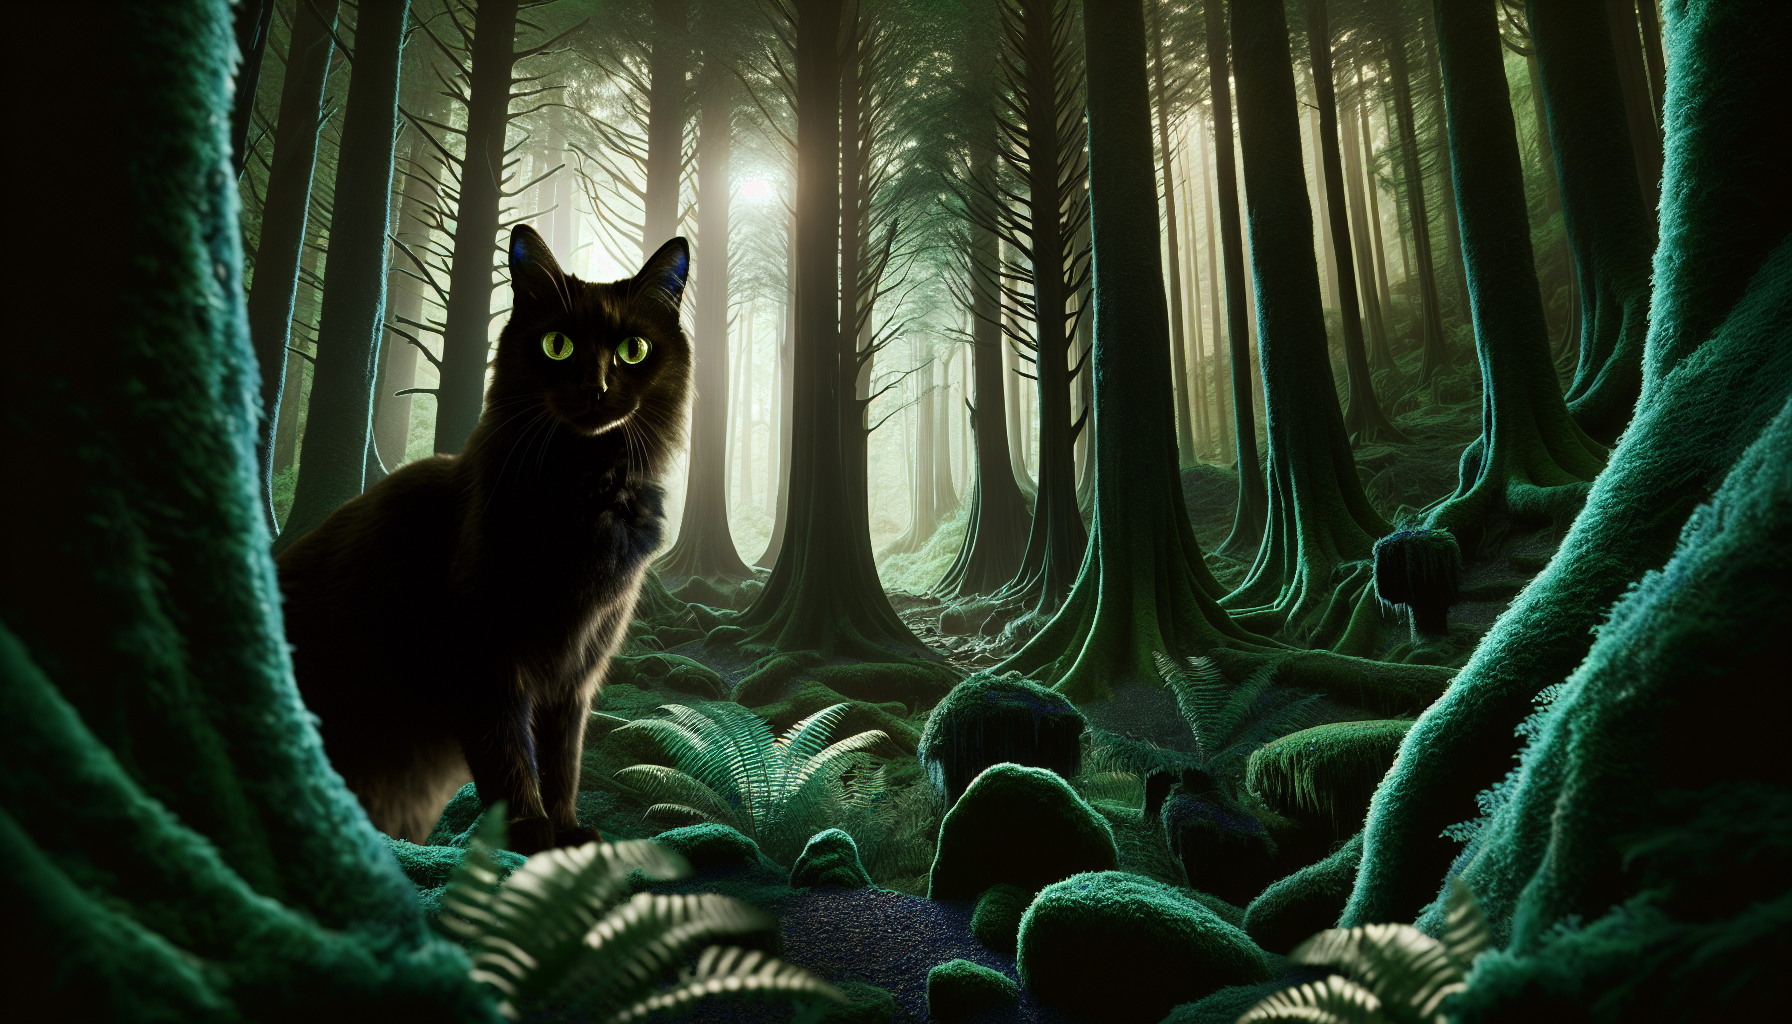

In [48]:
from IPython.display import Image
Image(image_path) 

## Speech API

#### Retrieve text embeddings using the Speech API. By default, all responses are cached.

In [49]:
success, message, speech_path = r.api_director.get_speech(
    text="Hello, my name is Thiago. I am a domestic service robot of the Autonomous Intelligent Systems group at University of Bonn.",
    model="tts-1-hd",
    voice="alloy",
    speed=1.0
)

2025-03-10 18:31:30.596 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved speech.


In [50]:
from IPython.display import Audio
Audio(speech_path)

## Usage Monitoring

#### You can retrieve detailed logs of your usage.

In [51]:
r.api_director.get_usage()

2025-03-10 18:31:33.920 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved usage in '0.004s'.


(True,
 "Successfully retrieved usage in '0.004s'.",
 {'embeddings': {'history': [{'stamp': '2025-01-28T16:07:49.667757',
     'model_name': 'mistral-embed',
     'input_tokens_uncached': 1,
     'api_endpoint': 'mistral'},
    {'stamp': '2025-01-29T17:10:24.664087',
     'model_name': 'mistral-embed',
     'input_tokens_uncached': 141,
     'api_endpoint': 'mistral'},
    {'stamp': '2025-01-29T17:10:26.389326',
     'model_name': 'mistral-embed',
     'input_tokens_uncached': 532,
     'api_endpoint': 'mistral'},
    {'stamp': '2025-02-07T11:56:27.691371',
     'model_name': 'text-embedding-3-large',
     'input_tokens_uncached': 8,
     'api_endpoint': 'openai'},
    {'stamp': '2025-02-10T17:46:29.200978',
     'model_name': 'text-embedding-3-large',
     'input_tokens_uncached': 142,
     'api_endpoint': 'openai'},
    {'stamp': '2025-02-10T17:46:53.371773',
     'model_name': 'text-embedding-3-large',
     'input_tokens_uncached': 13,
     'api_endpoint': 'openai'},
    {'stamp': '

#### For example, you can get the total amount of dollars spent on the Completions API or all APIs. (Currently only the Completions and Embeddings APIs are supported).

In [52]:
r.api_director.get_usage()[2]['completions']['total_dollars']

2025-03-10 18:31:36.713 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved usage in '0.004s'.


0.42063509999999993

In [53]:
r.api_director.get_usage()[2]['total_dollars']

2025-03-10 18:31:38.504 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved usage in '0.003s'.


0.4208802199999999

#### By providing ISO timestamps, you can truncate the usage considered before a timestamp, after a timestamp, or both.

In [56]:
import datetime
stamp_iso_start = (datetime.datetime.now() - datetime.timedelta(minutes=5)).isoformat()
stamp_iso_end = (datetime.datetime.now() - datetime.timedelta(minutes=2)).isoformat()

In [57]:
r.api_director.get_usage(stamp_start=stamp_iso_start, stamp_end=stamp_iso_end)

(True,
 "Successfully retrieved usage in '0.000s'.",
 {'completions': {'history': [{'stamp': '2025-03-10T18:27:13.747831',
     'api_endpoint': 'OpenAI',
     'model_name': 'gpt-4o',
     'input_tokens_uncached': 167,
     'output_tokens': 14},
    {'stamp': '2025-03-10T18:27:15.904926',
     'api_endpoint': 'OpenAI',
     'model_name': 'gpt-4o',
     'input_tokens_uncached': 190,
     'output_tokens': 37},
    {'stamp': '2025-03-10T18:27:17.679702',
     'api_endpoint': 'OpenAI',
     'model_name': 'gpt-4o',
     'input_tokens_uncached': 244,
     'output_tokens': 18},
    {'stamp': '2025-03-10T18:27:18.385749',
     'api_endpoint': 'OpenAI',
     'model_name': 'gpt-4o',
     'input_tokens_uncached': 285,
     'output_tokens': 15},
    {'stamp': '2025-03-10T18:27:19.093279',
     'api_endpoint': 'OpenAI',
     'model_name': 'gpt-4o',
     'input_tokens_uncached': 323,
     'output_tokens': 15},
    {'stamp': '2025-03-10T18:29:12.787365',
     'api_endpoint': 'OpenAI',
     'model_name

2025-03-10 18:31:53.298 [INFO] [nimbro_api_tutorial.api_director]: Successfully retrieved usage in '0.000s'.
